# Guardardemos el mejor modelo y el Vectorizer

In [2]:
import sys
import os
import pandas as pd
import re
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
sys.path.append(os.path.abspath('..'))  # Ajusta la ruta según la ubicación de 'training'
from training.etl import EDAdataset
from training.feature_engineer import PreprocesadorTexto
from utils.conexion import SQLConnection

In [3]:
params = {"medico": "PSICOLOGÍA","fechaini": "20230101","fechafin": "20250504"}
# sql_path = os.path.join("..", "sql_queries", "queries.sql")
sql_path = os.path.join("..",  "..", "sql_queries", "queries.sql")
sqlconection = SQLConnection(sql_path=sql_path, params=params)
df_conexion = sqlconection.generate_dataframe(nregistros=10000)
df_eda = EDAdataset(df_conexion)
df = df_eda.dataset_eda(df_conexion)

c:\Users\ISAIAS_QUINTERO\Desktop\Universiad\MLOps\Proyecto_Final\src\training\etl.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[column_name] = self.df[column_name].str.capitalize()


In [4]:
df.head()

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada
1,Femenino,68,T. de ansiedad,PSICOLOGÍA,"Paciente refiere ""de reumatología como que me ...",Atención psicológica en modalidad teleconsulta...,"Paciente refiere ""de reumatología como que me ..."
2,Femenino,38,Otros trastornos,PSICOLOGÍA,"Paciente refiere: ""Me empezaron a dar como uno...","Paciente alerta, colaboradora con apariencia o...","Paciente refiere: ""Me empezaron a dar como uno..."
3,Masculino,22,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""Me he sentido muy mal, en el...","Paciente a quien evaluó por primera vez, alert...","Paciente refiere ""Me he sentido muy mal, en el..."
4,Masculino,9,Otros trastornos,PSICOLOGÍA,"La madre refiere ""el viene por un acompañamien...",None,"La madre refiere ""el viene por un acompañamien..."
5,Masculino,28,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Estas cosas que han pasado m...","Paciente quien evalúo por primera vez, alerta,...","Paciente refiere ""Estas cosas que han pasado m..."


In [5]:
df.shape

(9808, 7)

In [6]:
stopwords={
            "medico", "paciente", "psicologo", "psicologa",
            "psicologia", "psicoterapeuta", "psicoterapia", "refiere"
        }

preprocesador = PreprocesadorTexto(df, stopwords=stopwords)
df_procesado, mapeos = preprocesador.procesar(
    columna_texto="concatenada", # Columna que contiene el texto a procesar
    columna_sexo="sexo", # Columna que contiene la variable sexo
    columna_grupo="grupo" # Columna que contiene la variable grupo
)

In [7]:
df_procesado.head()

,sexo,edad,grupo,especialidad_medica,subjetivo,objetivo,concatenada,sexo_codificado,grupo_codificado
1,Femenino,68,T. de ansiedad,PSICOLOGÍA,"Paciente refiere ""de reumatología como que me ...",Atención psicológica en modalidad teleconsulta...,"[reumatologa, autorizar, cita, mover, levantar...",0,2
2,Femenino,38,Otros trastornos,PSICOLOGÍA,"Paciente refiere: ""Me empezaron a dar como uno...","Paciente alerta, colaboradora con apariencia o...","[empezar, episodio, tom, pastilla, dormir, ten...",0,0
3,Masculino,22,T. externalizantes,PSICOLOGÍA,"Paciente refiere ""Me he sentido muy mal, en el...","Paciente a quien evaluó por primera vez, alert...","[sentido, trabajar, concentrar yo, cosa, vidat...",1,4
4,Masculino,9,Otros trastornos,PSICOLOGÍA,"La madre refiere ""el viene por un acompañamien...",None,"[madre, venir, acompañamiento, emocional, sepr...",1,0
5,Masculino,28,Otros trastornos,PSICOLOGÍA,"Paciente refiere ""Estas cosas que han pasado m...","Paciente quien evalúo por primera vez, alerta,...","[cosa, problema, empresa, ocasión, saludar, sa...",1,0


In [8]:
mapeos

{'sexo':         Sexo  Codigo
 0   Femenino       0
 1  Masculino       1,
 'grupo':                 Grupo  Codigo
 0    Otros trastornos       0
 1    T. de adaptación       1
 2      T. de ansiedad       2
 3       T. depresivos       3
 4  T. externalizantes       4
 5     T. personalidad       5}

In [9]:
# Dividir datos antes del vectorizador
X = df_procesado["concatenada"]
y = df_procesado["grupo_codificado"]

# Vectorización segura
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
vectorizer_RN = TfidfVectorizer()
# Convierte las listas de tokens a texto antes de vectorizar
X_train_text = X_train.apply(lambda tokens: " ".join(tokens))
X_test_text = X_test.apply(lambda tokens: " ".join(tokens))

X_train_vect = vectorizer_RN.fit_transform(X_train_text)
X_test_vect = vectorizer_RN.transform(X_test_text)



X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6865,), (2943,), (6865,), (2943,))

In [10]:
X_train_vect

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 656701 stored elements and shape (6865, 25470)>

In [11]:
X_test_vect

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 273044 stored elements and shape (2943, 25470)>

In [12]:
RN = RandomForestClassifier()
RN.fit(X_train_vect, y_train)
y_pred = RN.predict(X_test_vect)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6106014271151886
Precision: 0.6352552380825582
Recall: 0.6106014271151886
F1 Score: 0.5945099310685649
Confusion Matrix:
 [[283   3 161  30  17  19]
 [ 23  27  70  18   2   5]
 [ 58   2 850  46  11  14]
 [ 39   7 231 328   4   5]
 [ 76   2  84  15 110  33]
 [ 62   0  82  20   7 199]]


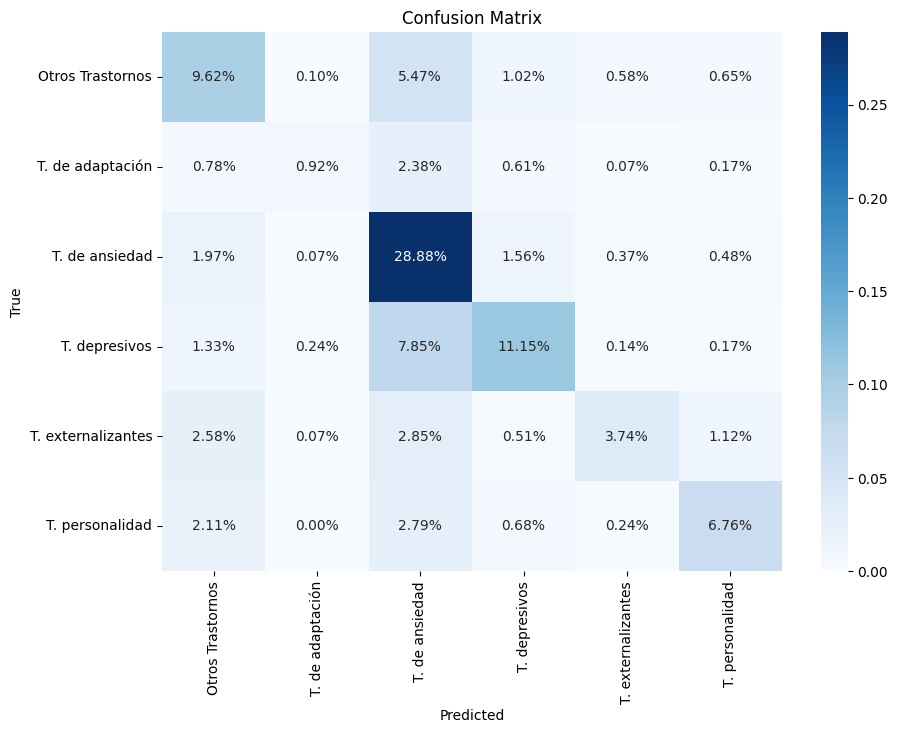

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Diccionario de mapeo
label_map = {0: "Otros Trastornos", 
             1: "T. de adaptación", 
             2: "T. de ansiedad", 
             3: "T. depresivos", 
             4: "T. externalizantes", 
             5: "T. personalidad"}

labels = list(label_map.keys())

cm = confusion_matrix(y_test, y_pred, labels=labels)

# Obtener los nombres para mostrar
nombres_labels = [label_map[i] for i in labels]

plt.figure(figsize=(10, 7))

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap="Blues", xticklabels=nombres_labels, yticklabels=nombres_labels)
plt.xlabel("Predicted") 
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [14]:
import joblib
import os

# Guardar el modelo y el vectorizador 
save_path = "best_model_vectorizer/"
os.makedirs(save_path, exist_ok=True)

joblib.dump(RN, os.path.join(save_path, "modelo_RN.pkl"))
joblib.dump(vectorizer_RN, os.path.join(save_path, "vectorizer_RN.pkl"))

['best_model_vectorizer/vectorizer_RN.pkl']